# Libraries

In [1]:
#Initializing spark session
import findspark
findspark.init()

In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc, desc, when, explode, array, lit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
#from imblearn.over_sampling import SMOTE


spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

sc=spark.sparkContext
sqlContext=SQLContext(sc)

23/11/29 19:02:04 WARN Utils: Your hostname, Sonalis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.29.197 instead (on interface en0)
23/11/29 19:02:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/29 19:02:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/homebrew/lib/python3.9/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# reading the dataframe for the assignment
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.")

There are 41188 rows 21 columns in the data.


In [4]:
# Data Preprocessing
df = df.withColumnRenamed("emp.var.rate", "emp_var_rate")
df = df.withColumnRenamed("cons.price.idx", "cons_price_idx")
df = df.withColumnRenamed("cons.conf.idx", "cons_conf_idx")
df = df.withColumnRenamed("nr.employed", "nr_employed")

# Data Exploration

In [5]:
df.show(5)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [6]:
df.summary().toPandas().transpose()

23/11/29 19:02:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
age,41188,40.02406040594348,10.421249980934043,17,32,38,47,98
job,41188,None,None,admin.,None,None,None,unknown
marital,41188,None,None,divorced,None,None,None,unknown
education,41188,None,None,basic.4y,None,None,None,unknown
default,41188,None,None,no,None,None,None,yes
housing,41188,None,None,no,None,None,None,yes
loan,41188,None,None,no,None,None,None,yes
contact,41188,None,None,cellular,None,None,None,telephone
month,41188,None,None,apr,None,None,None,sep


# Exploratory Data Visualizations 

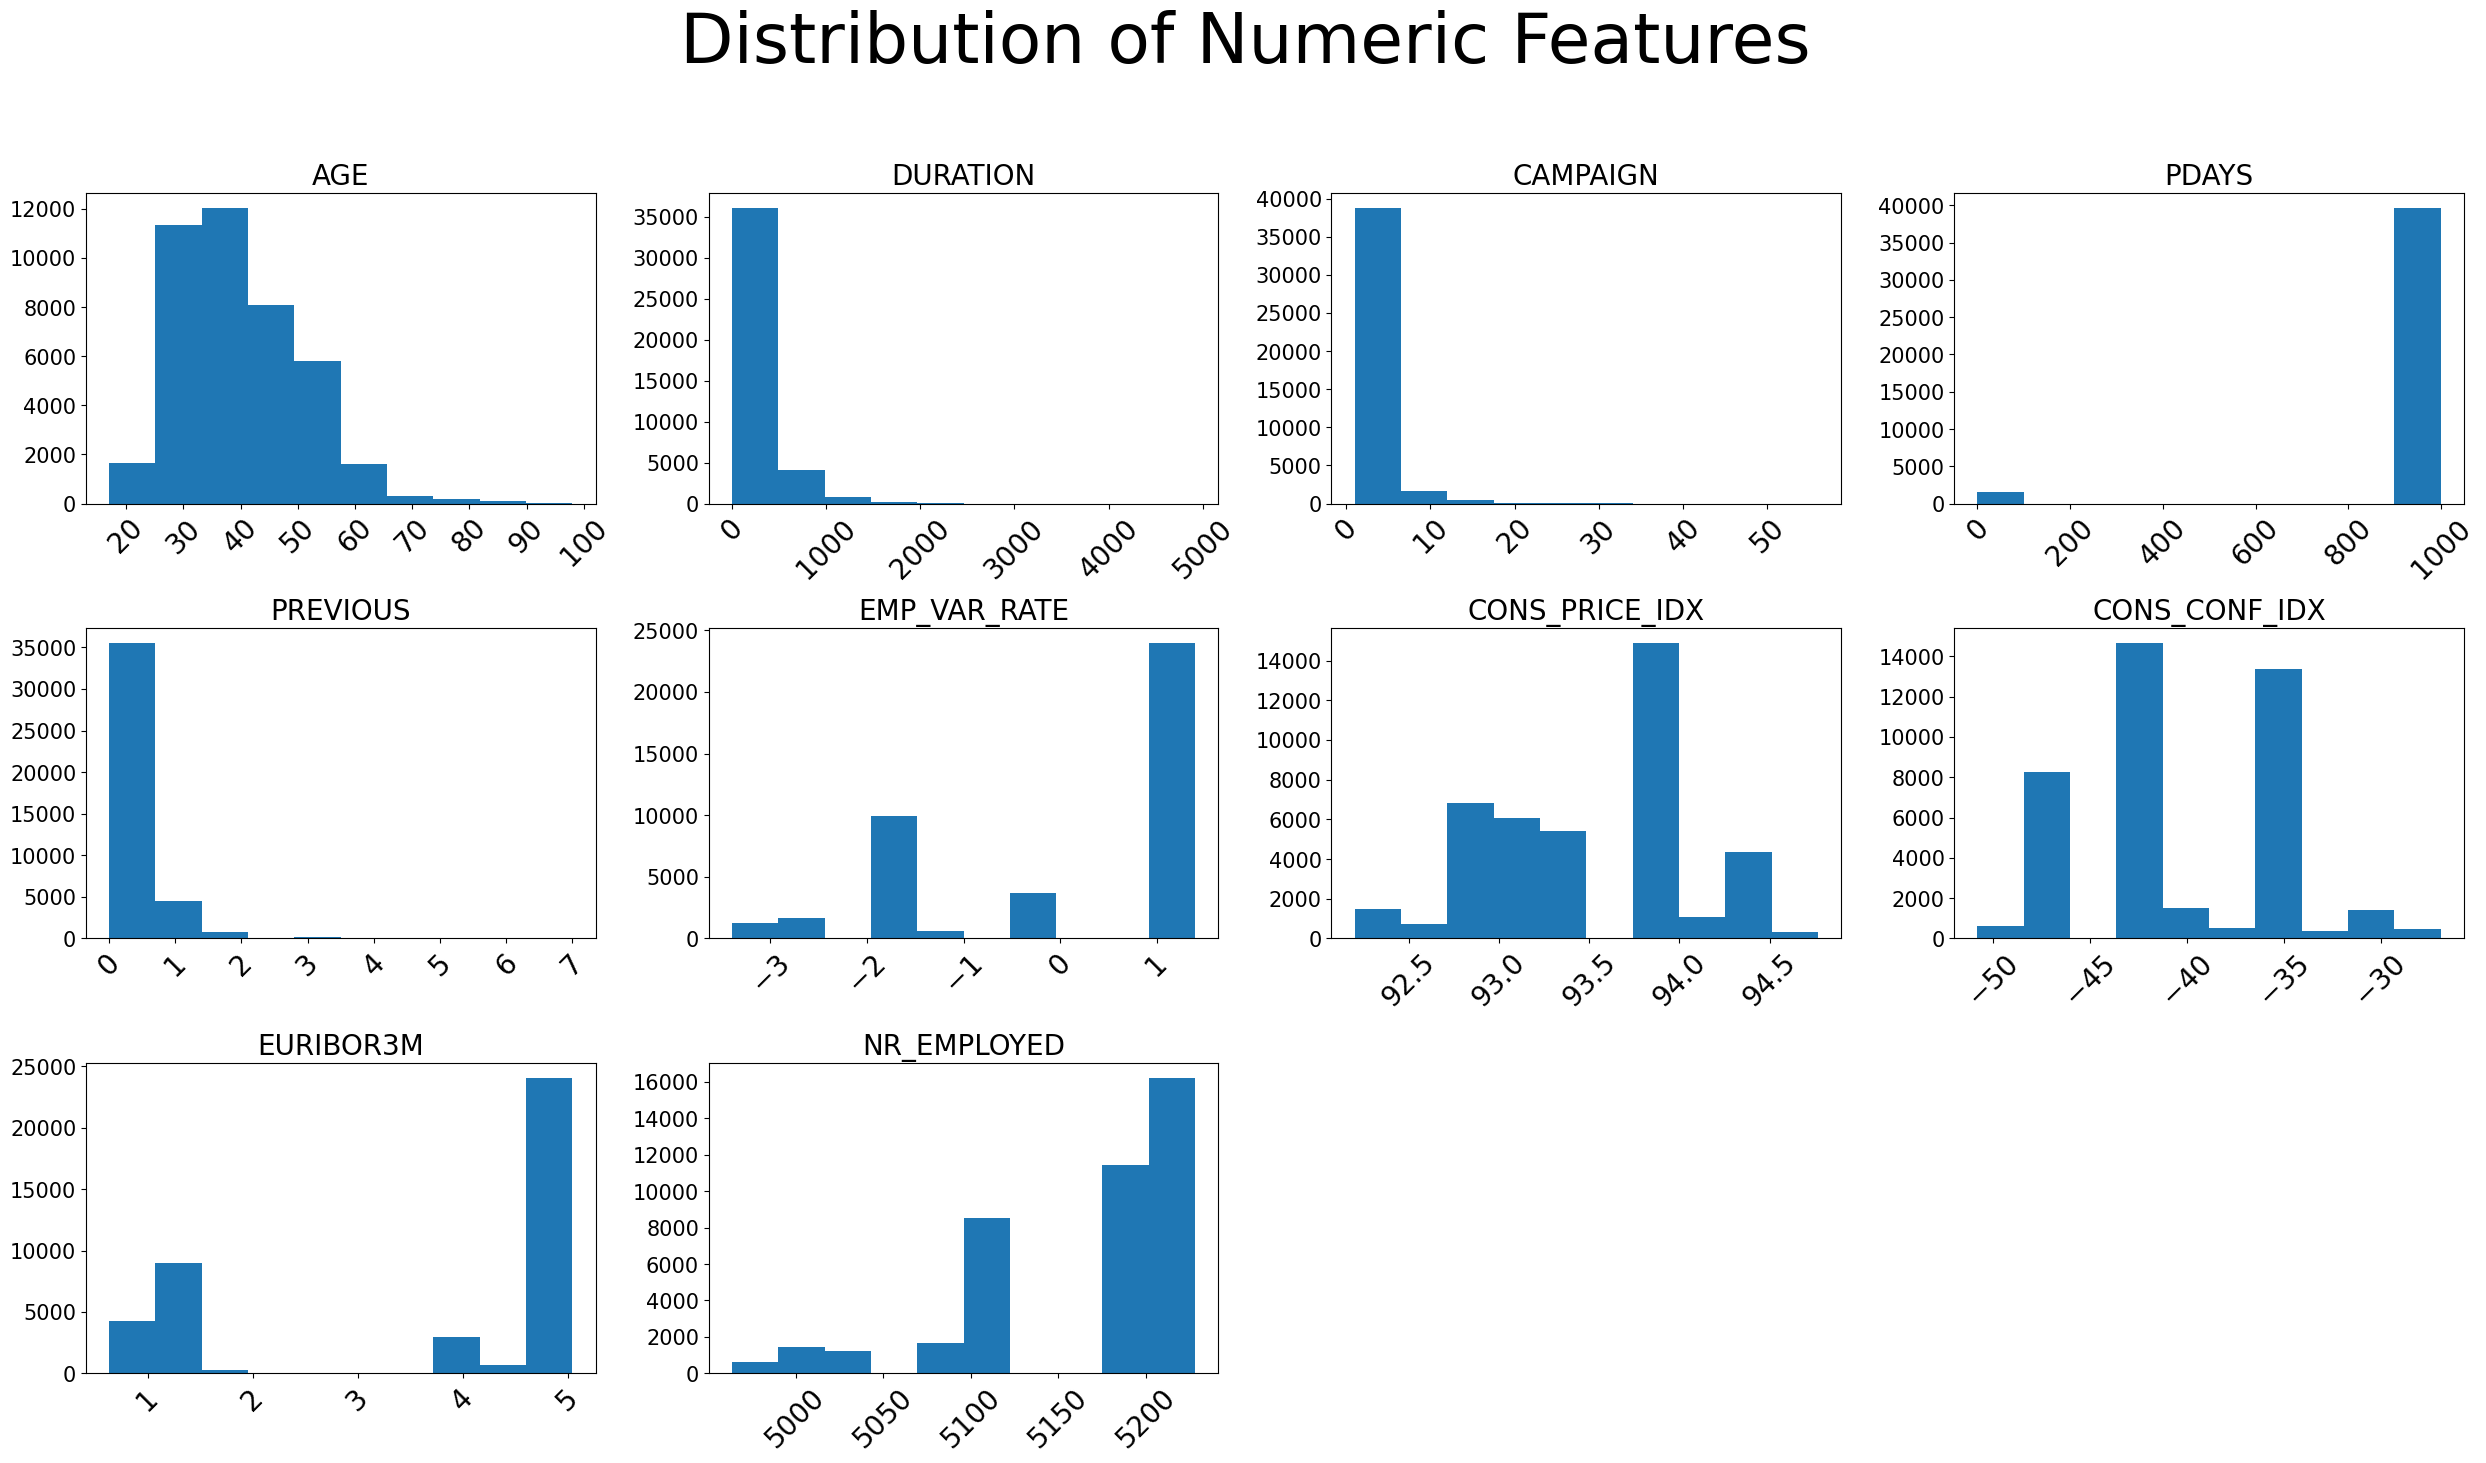

In [7]:
# Creating distribution for numeric variables
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Numeric Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [12]:
# Total string variables
string_features = [t[0] for t in df.dtypes if t[1] == 'string']

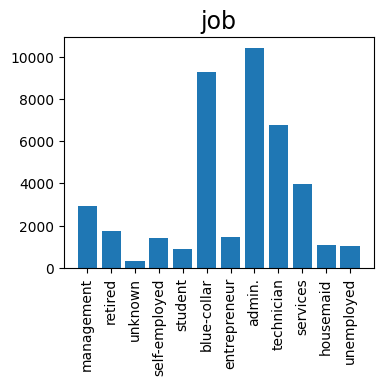

None

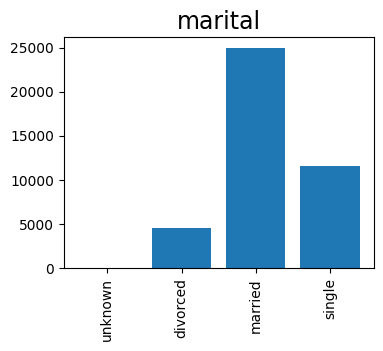

None

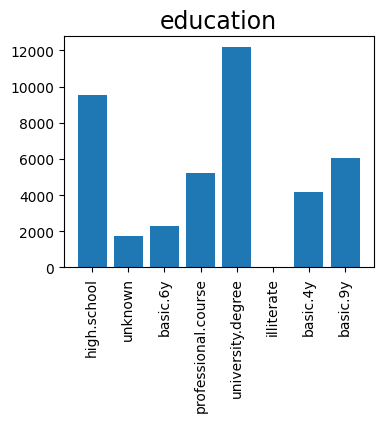

None

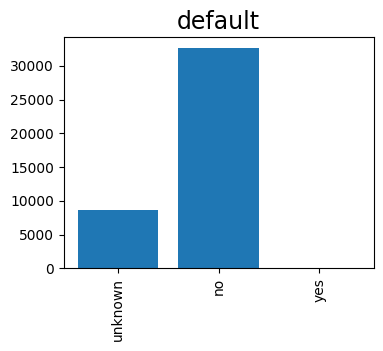

None

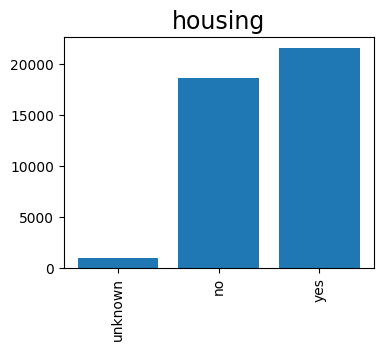

None

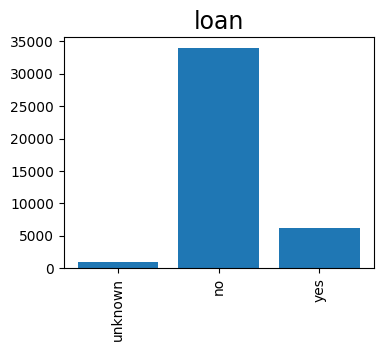

None

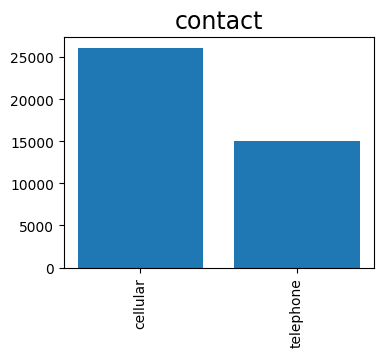

None

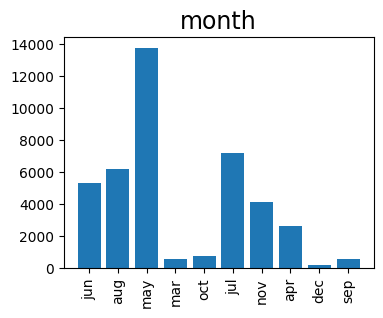

None

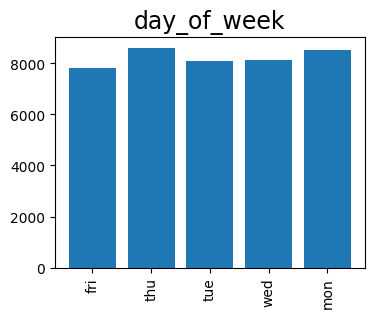

None

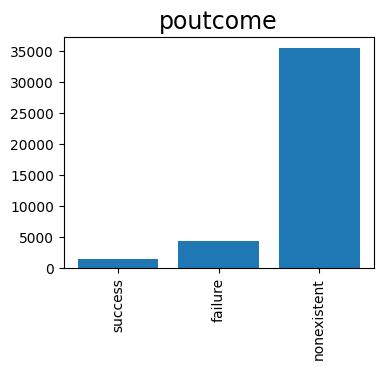

None

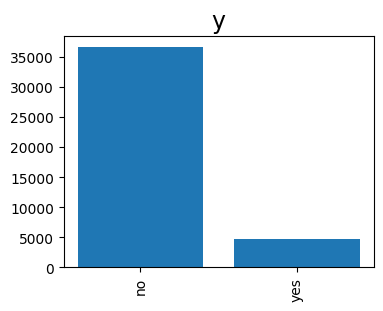

None

In [14]:
# Distribution for categorical variables
df.createOrReplaceTempView("DF")
for i in string_features:
    plt.figure(figsize=(4,3))
    new = spark.sql("select " + i + ", count(" + i + ") from DF group by " + i).toPandas()
    plt.bar(new.iloc[:,0], new.iloc[:,1])
    plt.xticks(rotation=90,fontsize=10)
    plt.title(i, fontdict={'fontsize': 17})
    display(plt.show())

## Correlation Matrix

In [15]:
# create df for correlation matrix
df1 = df[['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']]

In [16]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=columns, 
                            outputCol=vector_col)
my_vector = assembler.transform(df1).select(vector_col)
matrix = Correlation.corr(my_vector, vector_col)

23/11/29 19:04:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/29 19:04:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [17]:
# create list for correlation
matrix = Correlation.corr(my_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix)

[[1.0, -0.0008657050101409137, 0.004593580493413432, -0.034368951166858994, 0.02436474093611654, -0.00037068546744101216, 0.0008567149710785426, 0.12937161424620508, 0.010767429541674797, -0.017725131911927514], [-0.0008657050101409137, 1.0, -0.0716992262641536, -0.0475770154456121, 0.020640350701749122, -0.02796788448933175, 0.005312267762748574, -0.008172872813929487, -0.03289665570187576, -0.04470322316241789], [0.004593580493413432, -0.0716992262641536, 1.0, 0.052583573385026956, -0.07914147244884145, 0.15075380555786647, 0.12783591160945573, -0.013733098741901751, 0.13513251080435904, 0.14409489484472365], [-0.034368951166858994, -0.0475770154456121, 0.052583573385026956, 1.0, -0.587513856136789, 0.27100417426183293, 0.0788891087159522, -0.09134235397835197, 0.29689911239700334, 0.37260474218583123], [0.02436474093611654, 0.020640350701749122, -0.07914147244884145, -0.587513856136789, 1.0, -0.42048910941333256, -0.2031299674503254, -0.05093635090673017, -0.45449365360773475, -0.50

In [18]:
# show correlation matrix
corr_df = spark.createDataFrame(corrmatrix,columns)
corr_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 age|            duration|            campaign|               pdays|            previous|        emp_var_rate|      cons_price_idx|       cons_conf_idx|           euribor3m|         nr_employed|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|-8.65705010140913...|0.004593580493413432|-0.03436895116685...| 0.02436474093611654|-3.70685467441012...|8.567149710785426E-4| 0.12937161424620508|0.010767429541674797|-0.01772513191192...|
|-8.65705010140913...|                 1.0| -0.0716992262641536| -0.0475770154456121|0.020640350701749122|-0.02796788448933175|0.005312267762748574|-0.0

/var/folders/1q/qj77hns50_n2lj1c72ffdt9r0000gn/T/ipykernel_75677/3947413437.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
/var/folders/1q/qj77hns50_n2lj1c72ffdt9r0000gn/T/ipykernel_75677/3947413437.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


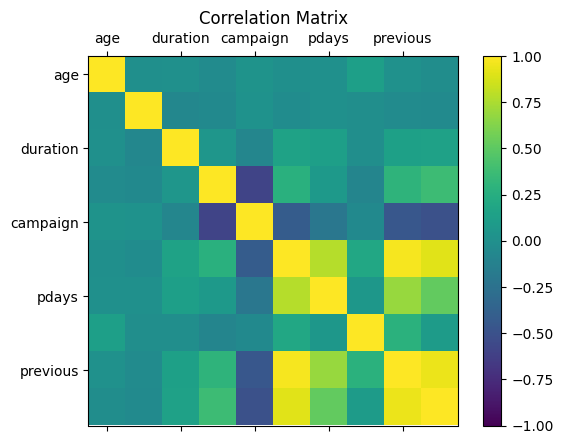

In [19]:
# plotting matrix
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, columns, 234)

## Bivariate Analysis

In [20]:
# Importing libraries
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

# conversion
df2 = df.toPandas()

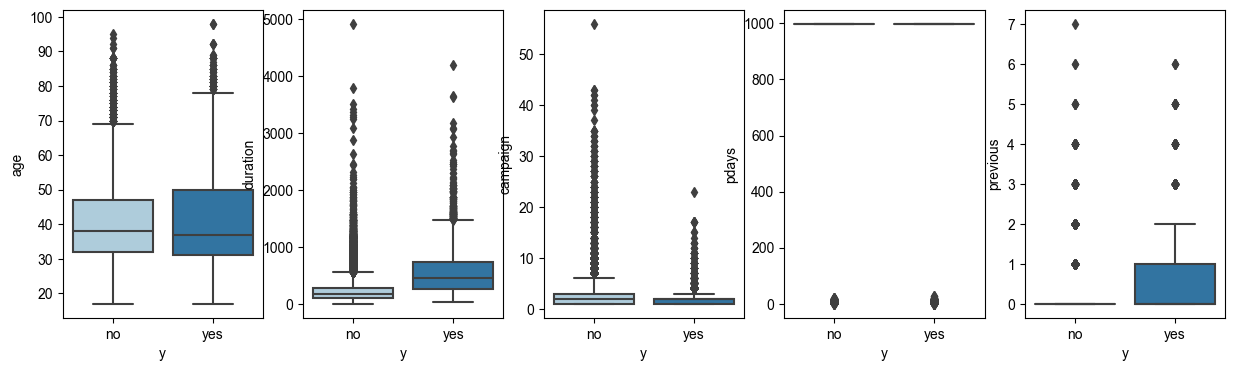

In [21]:
# creating boxplots
sns.set_palette('Paired')
f, axes = plt.subplots(nrows=1, ncols=5, figsize = (15,4))
sns.set_style('darkgrid')

fig1 = sns.boxplot(x='y', y='age', data=df2, ax=axes[0])
fig2 = sns.boxplot(x='y', y='duration', data=df2, ax=axes[1])
fig3 = sns.boxplot(x='y', y='campaign', data=df2, ax=axes[2])
fig4 = sns.boxplot(x='y', y='pdays', data=df2, ax=axes[3])
fig5 = sns.boxplot(x='y', y='previous', data=df2, ax=axes[4])

plt.show()

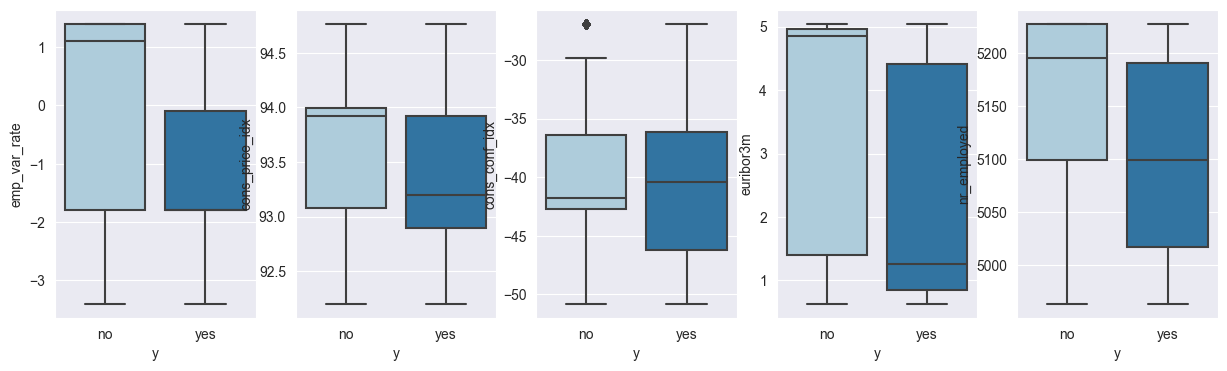

In [22]:
# creating boxplots
sns.set_palette('Paired')
f, axes = plt.subplots(nrows=1, ncols=5, figsize = (15,4))
sns.set_style('darkgrid')

fig6 = sns.boxplot(x='y', y='emp_var_rate', data=df2, ax=axes[0])
fig7 = sns.boxplot(x='y', y='cons_price_idx', data=df2, ax=axes[1])
fig8 = sns.boxplot(x='y', y='cons_conf_idx', data=df2, ax=axes[2])
fig9 = sns.boxplot(x='y', y='euribor3m', data=df2, ax=axes[3])
fig10 = sns.boxplot(x='y', y='nr_employed', data=df2, ax=axes[4])

plt.show()

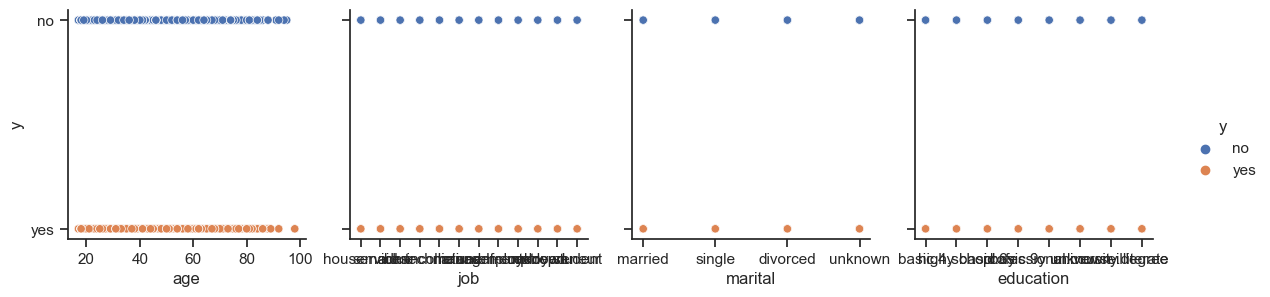

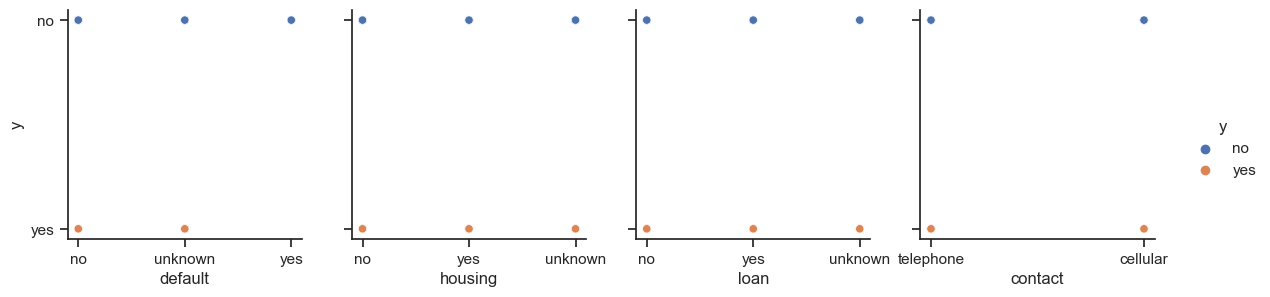

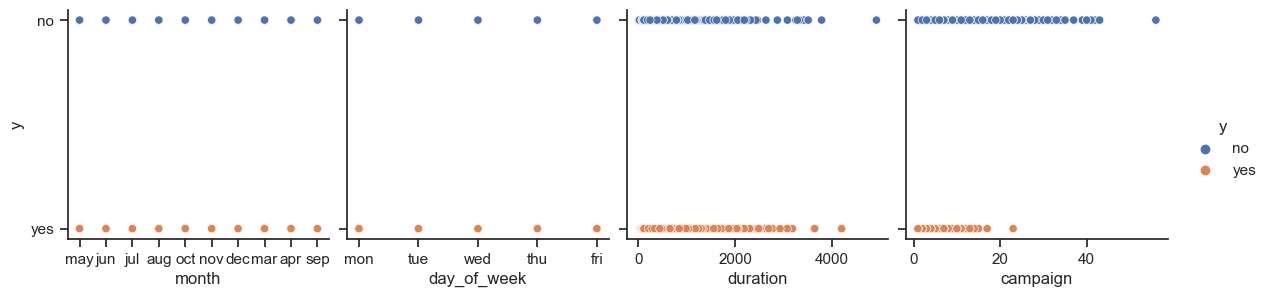

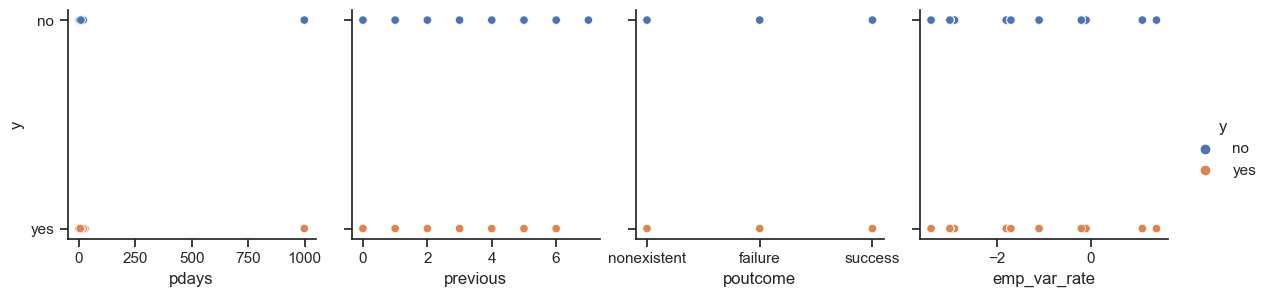

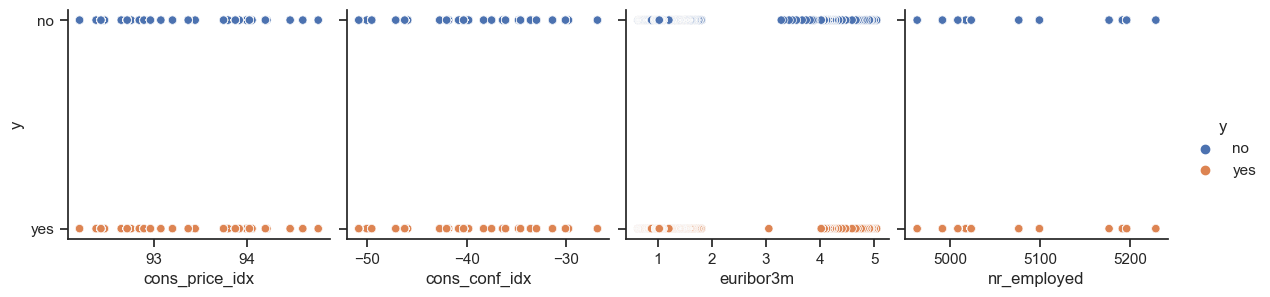

In [23]:
# creating pair plots
import seaborn as sns
sns.set(style="ticks")

for x in range(0,len(df.columns[:-1]), 4):
    sns.pairplot(df.toPandas(), x_vars=df.columns[x:(x+4)], y_vars="y", hue="y", height = 3)
    plt.show()

In [24]:
# Checking for null values in the dataset
{col:df.filter(df[col].isNull()).count() for col in df.columns}

{'age': 0,
 'job': 0,
 'marital': 0,
 'education': 0,
 'default': 0,
 'housing': 0,
 'loan': 0,
 'contact': 0,
 'month': 0,
 'day_of_week': 0,
 'duration': 0,
 'campaign': 0,
 'pdays': 0,
 'previous': 0,
 'poutcome': 0,
 'emp_var_rate': 0,
 'cons_price_idx': 0,
 'cons_conf_idx': 0,
 'euribor3m': 0,
 'nr_employed': 0,
 'y': 0}

In [25]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



In [26]:
# Total numeric variables
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,258.2850101971448,259.27924883646455,0,4918
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,962.4754540157328,186.910907344741,0,999
previous,41188,0.17296299893172767,0.49490107983928927,0,7
emp_var_rate,41188,0.08188550063178966,1.57095974051703,-3.4,1.4
cons_price_idx,41188,93.5756643682899,0.5788400489540823,92.201,94.767
cons_conf_idx,41188,-40.502600271918276,4.628197856174573,-50.8,-26.9
euribor3m,41188,3.621290812858533,1.7344474048512595,0.634,5.045


In [27]:
# cardinality for the categorical variables
from pyspark.sql.functions import countDistinct
cardinality = [countDistinct(c).alias(c) for c in string_features]
df.select(cardinality).show()

+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+
|job|marital|education|default|housing|loan|contact|month|day_of_week|poutcome|  y|
+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+
| 12|      4|        8|      3|      3|   3|      2|   10|          5|       3|  2|
+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+---+



In [28]:
for i in string_features:
    df.select(i).distinct().show()

+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+

+--------+
| marital|
+--------+
| unknown|
|divorced|
| married|
|  single|
+--------+

+-------------------+
|          education|
+-------------------+
|        high.school|
|            unknown|
|           basic.6y|
|professional.course|
|  university.degree|
|         illiterate|
|           basic.4y|
|           basic.9y|
+-------------------+

+-------+
|default|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+-------+
|housing|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+-------+
|   loan|
+-------+
|unknown|
|     no|
|    yes|
+-------+

+---------+
|  contact|
+---------+
| cellular|
|telephone|
+---------+

+-----+
|month|
+-----+
|  jun|
|  aug|
|  may|
|  mar|
|  oct|
|  jul|
|  nov|
|  apr|
|  dec|
|  sep|

# Splitting the dataset into training and test 

In [8]:
df1 = df
train, test = df1.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 32894
Test Dataset Count: 8294


## Oversample the minority class

In [9]:
# compute ratio needed to oversample

from pyspark.sql.functions import col
major_df = train.filter(col("y") == 'no')
minor_df = train.filter(col("y") == 'yes')
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 7


In [10]:
# oversampling
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
train = major_df.unionAll(oversampled_df)

# Feature Engineering/ Data Preprocessing

In [29]:
# For the string features
stages = []
for col in string_features[:-1]:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + 'coded')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"])
    stages += [stringIndexer, encoder]

# for the outcome label
label_string = StringIndexer(inputCol= 'y', outputCol='label')
stages += [label_string]

# for the numerical columns as well
assemblerInputs = [c + 'classVec' for c in string_features[:-1]] + numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='vectorized_features', handleInvalid='skip')
stages += [assembler]

# scale down the features into something usable
scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')
stages += [scaler]

In [30]:
# fitting pipeline to train dataset
cols = train.columns
pipeline = Pipeline(stages=stages)
pipelinemodel = pipeline.fit(train)
train = pipelinemodel.transform(train)
selectedCols = ['label', 'features'] + cols
train_set = train.select(selectedCols)

In [31]:
# fitting pipeline to test dataset
cols = test.columns
test = pipelinemodel.transform(test)
selectedCols = ['label', 'features'] + cols
test_set = test.select(selectedCols)

# Logistic Regression

In [30]:
# training for the logistic regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train_set)
predictions = lrModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[2.584896516024269, -2.584896516024269]",0.0,"[0.9298831968782861, 0.07011680312171387]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[0.2997056847910855, -0.2997056847910855]",0.0,"[0.5743705674367228, 0.42562943256327723]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[-1.7709120160391265, 1.7709120160391265]",1.0,"[0.145428947502546, 0.854571052497454]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[-0.08391178579704928, 0.08391178579704928]",1.0,"[0.47903435402818945, 0.5209656459718106]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[0.5272198990881591, -0.5272198990881591]",0.0,"[0.6288344644875611, 0.3711655355124389]"


In [32]:
# confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 821  121]
 [ 943 6409]]


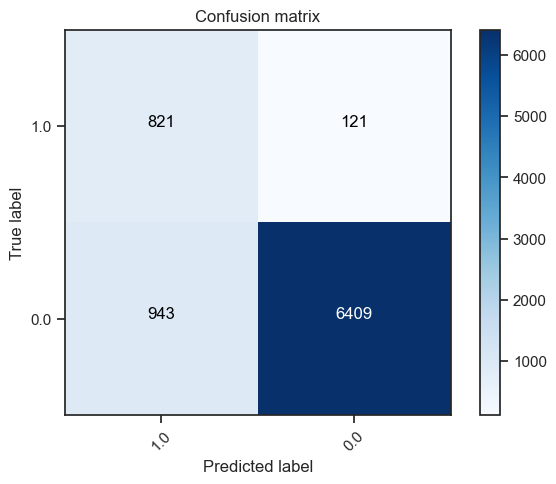

In [33]:
# plotting confusion matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [34]:
# Model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8717144924041476


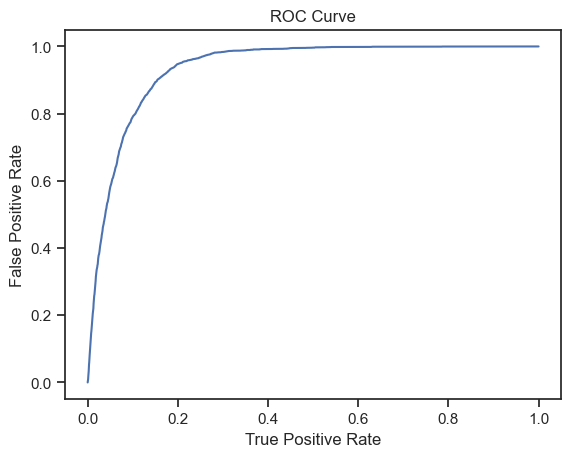

Training set area under ROC: 0.9354460678322531


In [35]:
# Training ROC for the model
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area under ROC: ' + str(trainingSummary.areaUnderROC))

In [42]:
# Testing ROC for model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9487551519120984


# Decision Tree

In [37]:
# creating model
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dtcModel = dtc.fit(train_set)

predictions = dtcModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[15545.0, 203.0]",0.0,"[0.9871094742189485, 0.012890525781051562]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[394.0, 756.0]",1.0,"[0.3426086956521739, 0.6573913043478261]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[499.0, 1351.0]",1.0,"[0.26972972972972975, 0.7302702702702702]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[394.0, 756.0]",1.0,"[0.3426086956521739, 0.6573913043478261]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[456.0, 105.0]",0.0,"[0.8128342245989305, 0.18716577540106952]"


In [38]:
# Confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 845   97]
 [1065 6287]]


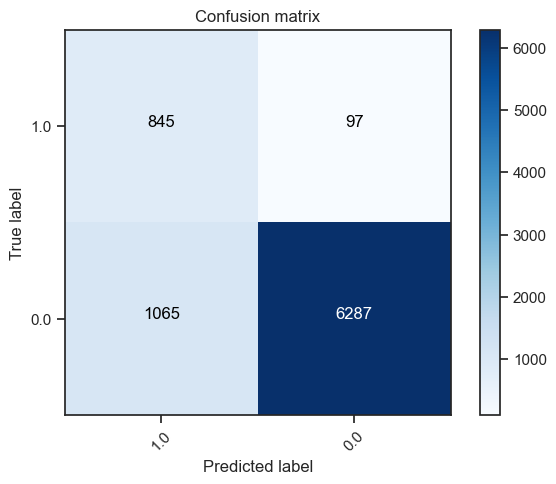

In [39]:
# plotting confusion matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [40]:
# Model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8598987219676875


/opt/homebrew/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Testing Area Under ROC: 0.9487551519120984


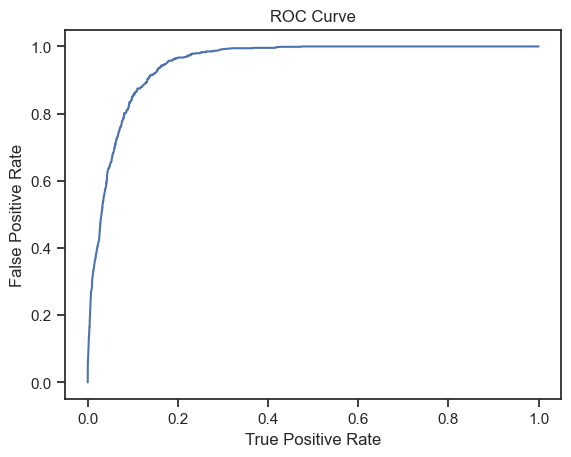

In [39]:
# plotting ROC curve
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
print("Testing Area Under ROC: " + str(CurveMetrics(preds).areaUnderROC))

In [42]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8454058170401226


# Random Forest

In [43]:
# creating model
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_set)
predictions = rfModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[15.70173487374166, 4.29826512625834]",0.0,"[0.785086743687083, 0.21491325631291697]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[11.651919424837939, 8.348080575162061]",0.0,"[0.5825959712418969, 0.41740402875810306]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[6.513852592987815, 13.486147407012187]",1.0,"[0.3256926296493908, 0.6743073703506093]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[11.502665799442148, 8.49733420055785]",0.0,"[0.5751332899721074, 0.4248667100278925]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[11.288581525072555, 8.711418474927447]",0.0,"[0.5644290762536277, 0.43557092374637235]"


In [44]:
# Confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 791  151]
 [1094 6258]]


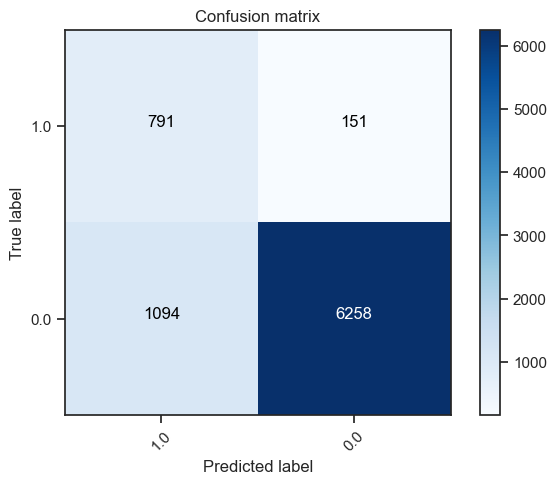

In [45]:
# plotting cm
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [46]:
# Model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8498914878225223


/opt/homebrew/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Testing Area Under ROC: 0.9247992660257951


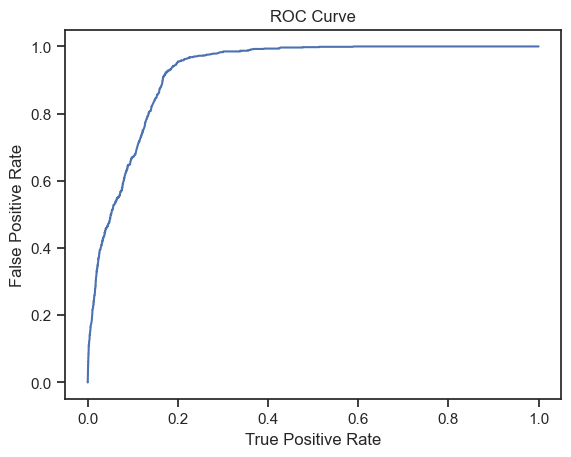

In [47]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
print("Testing Area Under ROC: " + str(CurveMetrics(preds).areaUnderROC))

In [48]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9247992660257945


# Gradient Boosting Classifier

In [32]:
# creating model
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_set)
predictions = gbtModel.transform(test_set)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[0.8946116877099392, -0.8946116877099392]",0.0,"[0.8568320336828306, 0.14316796631716944]"
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[-0.2299624153833881, 0.2299624153833881]",1.0,"[0.38700365624366967, 0.6129963437563304]"
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[-0.36128924829402737, 0.36128924829402737]",1.0,"[0.32682543331607306, 0.673174566683927]"
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[-0.3402947594235597, 0.3402947594235597]",1.0,"[0.3361297408000733, 0.6638702591999267]"
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...","[0.9876639156768855, -0.9876639156768855]",0.0,"[0.878182224388506, 0.12181777561149398]"


In [33]:
# Confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 862   80]
 [1032 6320]]


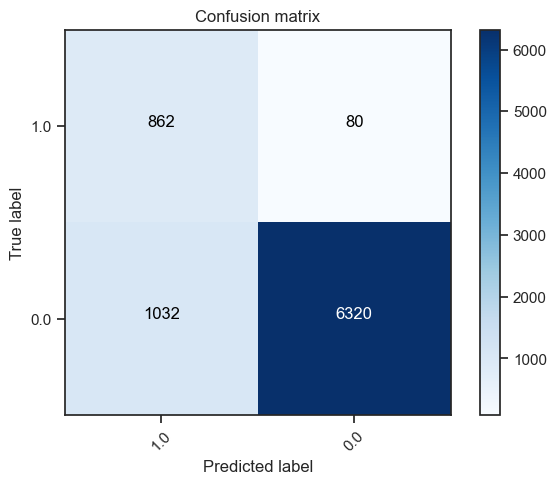

In [34]:
# plotting confusion matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [35]:
# Model accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8659271762720039


Testing Area Under ROC: 0.9487551519120982


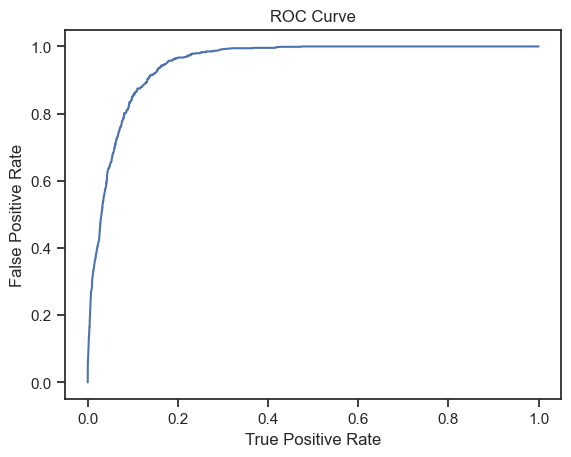

In [40]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.plot(x_val, y_val)
print("Testing Area Under ROC: " + str(CurveMetrics(preds).areaUnderROC))

In [43]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9487551519120981


In [44]:
gbtModel.featureImportances

SparseVector(53, {0: 0.0, 1: 0.0028, 3: 0.0004, 4: 0.0003, 5: 0.0032, 7: 0.0017, 8: 0.0002, 10: 0.0007, 13: 0.0009, 14: 0.0048, 17: 0.0006, 18: 0.0014, 21: 0.0038, 22: 0.0005, 25: 0.0011, 27: 0.0127, 28: 0.0023, 29: 0.0011, 32: 0.0009, 33: 0.0097, 34: 0.0214, 36: 0.0056, 37: 0.004, 38: 0.0094, 39: 0.0026, 40: 0.0058, 41: 0.0002, 42: 0.0087, 43: 0.0257, 44: 0.4178, 45: 0.0132, 46: 0.0098, 47: 0.0021, 48: 0.1047, 49: 0.0211, 50: 0.0465, 51: 0.1028, 52: 0.1498})

In [49]:
#Saving model as serialized object
gbtModel.save("GBTClassifierModelPickleFile")

In [50]:
#Loading above model
pipelineModel = gbtModel.load("GBTClassifierModelPickleFile")

# K Means

In [58]:
# creating k-means clusters
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(train_set.select('features'))
transformed = model.transform(train_set)

In [59]:
# counting records in each cluster
transformed.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|20405|
|         3|15429|
|         4| 7981|
|         2| 2981|
|         0| 8286|
+----------+-----+



In [60]:
transformed.filter(transformed.prediction == 0).toPandas().head(5)

,label,features,age,job,marital,education,default,housing,loan,contact,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",19,student,single,basic.9y,unknown,yes,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no,0
1,0.0,"(0.0, 2.5553761110921385, 0.0, 0.0, 0.0, 0.0, ...",22,blue-collar,single,basic.6y,unknown,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,no,0
2,0.0,"(0.0, 2.5553761110921385, 0.0, 0.0, 0.0, 0.0, ...",22,blue-collar,single,basic.6y,unknown,unknown,unknown,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,0
3,0.0,"(0.0, 2.5553761110921385, 0.0, 0.0, 0.0, 0.0, ...",22,blue-collar,single,basic.6y,unknown,yes,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no,0
4,0.0,"(0.0, 2.5553761110921385, 0.0, 0.0, 0.0, 0.0, ...",22,blue-collar,single,unknown,unknown,no,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no,0


In [61]:
transformed.filter(transformed.prediction == 1).toPandas().head(5)

,label,features,age,job,marital,education,default,housing,loan,contact,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,prediction
0,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20,admin.,single,high.school,no,no,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no,1
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.665...",20,entrepreneur,single,high.school,no,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,1
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.665...",20,entrepreneur,single,high.school,no,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,1
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.665...",20,entrepreneur,single,high.school,no,no,no,telephone,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,1
4,0.0,"(0.0, 0.0, 0.0, 3.5498633758318805, 0.0, 0.0, ...",20,services,single,high.school,no,no,no,telephone,...,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no,1


In [62]:
transformed.filter(transformed.prediction == 2).toPandas().head(5)

,label,features,age,job,marital,education,default,housing,loan,contact,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",36,retired,married,high.school,no,yes,no,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.435,5099.1,no,2
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",37,retired,divorced,basic.9y,unknown,yes,no,cellular,...,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,no,2
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",40,retired,divorced,basic.4y,no,no,no,cellular,...,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no,2
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",40,retired,single,basic.4y,no,yes,yes,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,no,2
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 4.107637800298967, 0...",44,retired,divorced,professional.course,no,yes,no,cellular,...,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,2


In [63]:
transformed.filter(transformed.prediction == 3).toPandas().head(5)

,label,features,age,job,marital,education,default,housing,loan,contact,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",18,student,single,high.school,no,yes,yes,cellular,...,999,0,nonexistent,-1.8,92.843,-50.0,1.687,5099.1,no,3
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",19,student,single,basic.9y,no,no,no,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.410,5099.1,no,3
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",19,student,single,basic.9y,no,no,no,cellular,...,999,0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,no,3
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",19,student,single,unknown,no,yes,no,telephone,...,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no,3
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",20,student,single,basic.9y,no,yes,no,cellular,...,999,0,nonexistent,-1.8,92.843,-50.0,1.538,5099.1,no,3


In [64]:
transformed.filter(transformed.prediction == 4).toPandas().head(5)

,label,features,age,job,marital,education,default,housing,loan,contact,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,prediction
0,0.0,"(0.0, 0.0, 0.0, 3.5498633758318805, 0.0, 0.0, ...",26,services,single,high.school,no,no,no,cellular,...,1,3,success,-1.8,93.075,-47.1,1.483,5099.1,no,4
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.61841138...",28,self-employed,married,university.degree,no,yes,no,telephone,...,999,1,failure,-0.1,93.200,-42.0,4.120,5195.8,no,4
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.4451539153755...",28,student,single,university.degree,no,yes,no,cellular,...,11,2,failure,-1.8,93.075,-47.1,1.453,5099.1,no,4
3,0.0,"(0.0, 0.0, 2.708579337991304, 0.0, 0.0, 0.0, 0...",28,technician,single,professional.course,no,yes,no,cellular,...,999,2,failure,-1.8,93.075,-47.1,1.483,5099.1,no,4
4,0.0,"(2.2575892509892865, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29,admin.,divorced,professional.course,no,no,yes,cellular,...,999,1,failure,-0.1,93.200,-42.0,4.120,5195.8,no,4


In [65]:
# Pipeline stages
stages = []

In [66]:
from pyspark.ml.feature import PCA
# Apply PCA for dimensionality reduction
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
stages += [pca]

In [67]:
# Define and add the K-means model to the pipeline
kmeans = KMeans().setK(3).setSeed(1).setFeaturesCol("pcaFeatures")
stages += [kmeans]

In [68]:
# Create a Pipeline
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(train)

# Transform the test set
test_set = pipelineModel.transform(test)


23/11/29 19:01:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [69]:
# Evaluate clustering by computing Silhouette score
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol="pcaFeatures")
silhouette = evaluator.evaluate(test_set)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.5687624535572995


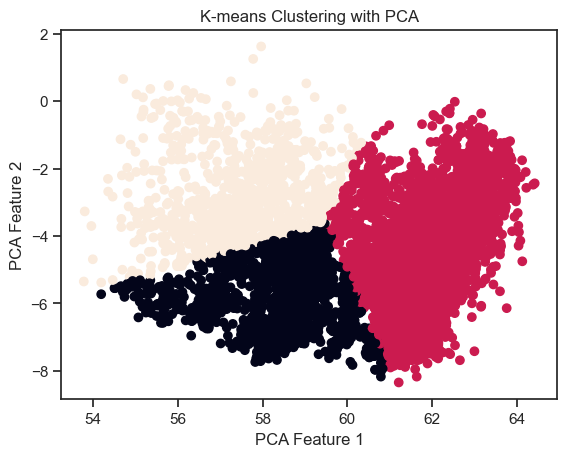

In [70]:
# Convert predictions to Pandas DataFrame for plotting
pandas_df = test_set.toPandas()

# Extract the PCA features for plotting
pandas_df['PCA1'] = pandas_df['pcaFeatures'].apply(lambda x: x[0])
pandas_df['PCA2'] = pandas_df['pcaFeatures'].apply(lambda x: x[1])

plt.scatter(pandas_df['PCA1'], pandas_df['PCA2'], c=pandas_df['prediction'])
plt.title("K-means Clustering with PCA")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()